# Simple demo of semi-NMF on synthetic data

The model is described here: https://www.overleaf.com/project/649e4d41313d17d01bde7cfb




In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cfos import seminmf
from tensorflow_probability.substrates import jax as tfp
from jax.image import resize
tfd = tfp.distributions

## Make synthetic 2D dataset for testing

In [2]:
key = jr.PRNGKey(0)
num_mice = 20
height, width = 100, 100
downsample_factor = 4
num_factors = 3
emission_noise_scale = 0.5
loading_scale = 10.0

# Make some simple factors
xx, yy = jnp.meshgrid(jnp.arange(width // downsample_factor), jnp.arange(height // downsample_factor))
true_weights = jnp.zeros((num_factors, height // downsample_factor, width // downsample_factor))
true_weights = true_weights.at[0].set(jnp.where((xx >= 2) & (xx < 5) & (yy >= 5) & (yy < 8), 1.0, 0.0))
true_weights = true_weights.at[1].set(jnp.where((xx >= 15) & (xx < 19) & (yy >= 7) & (yy < 12), 1.0, 0.0))
true_weights = true_weights.at[2].set(jnp.where(((xx - 10)**2 + (yy - 20)**2) <= 4**2, 1.0, 0.0))
true_weights /= true_weights.sum(axis=(1, 2), keepdims=True)

# Sample data
k1, k2 = jr.split(key, 2)

# Sample factors
true_loadings = tfd.Laplace(0.0, loading_scale).sample(seed=k1, sample_shape=(num_mice, num_factors))

# Sample data
mus = jnp.einsum('mk, khw->mhw', true_loadings, resize(true_weights, (num_factors, height, width), method="linear"))
data = tfd.Normal(mus, emission_noise_scale).sample(seed=k2)

## Plot factors and a few data points

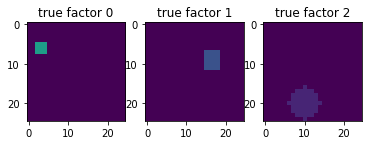

In [3]:
# Plot the factors
fig, axs = plt.subplots(1, num_factors)
for k in range(num_factors):
    axs[k].imshow(true_weights[k], vmax=0.2)
    axs[k].set_title("true factor {}".format(k))

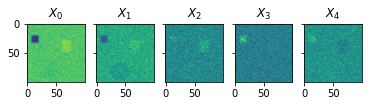

In [4]:
# Plot some of the data
fig, axs = plt.subplots(1, 5, sharey=True)
for m, ax in enumerate(axs):
    axs[m].imshow(data[m])
    axs[m].set_title(r"$X_{}$".format(m))

## Fit the model!

In [5]:
# Fit the model
losses, loadings, weights = \
    seminmf.fit_batch(data, num_factors,
                      emission_noise_scale=emission_noise_scale,
                      loading_scale=loading_scale,
                      num_iters=5,
                      verbosity=0,
                      key=1)

initial loss:  0.7307119


  0%|          | 0/5 [00:00<?, ?it/s]

Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.7228292
Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.7227511
Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.72272265
Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.72270304
Updating loadings


  0%|          | 0/20 [00:00<?, ?it/s]

Updating factors
loss:  0.7226898


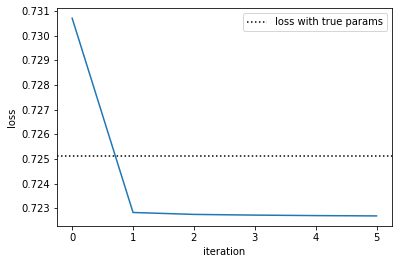

In [6]:
# Plot the losses
plt.figure()
plt.plot(losses)
plt.axhline(seminmf.compute_loss(data, true_loadings, true_weights, emission_noise_scale),
            ls=':', color='k', label='loss with true params')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

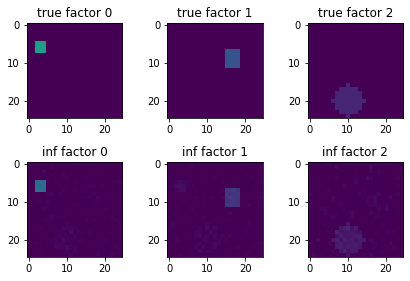

In [7]:
# Plot the factors
fig, axs = plt.subplots(2, num_factors)
for k in range(num_factors):
    axs[0, k].imshow(true_weights[k], vmax=0.2)
    axs[0, k].set_title("true factor {}".format(k))

    axs[1, k].imshow(weights[k], vmax=0.2)
    axs[1, k].set_title("inf factor {}".format(k))
plt.tight_layout()

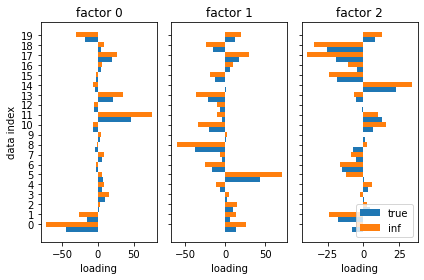

In [8]:
# Plot the loadings
fig, axs = plt.subplots(1, num_factors, sharey=True)
for k in range(num_factors):
    axs[k].barh(jnp.arange(num_mice), true_loadings[:, k], height=0.5, label='true')
    axs[k].barh(jnp.arange(num_mice)+.5, loadings[:, k], height=0.5, label='inf')
    axs[k].set_title("factor {}".format(k))
    axs[k].set_yticks(jnp.arange(num_mice) + .5)
    axs[k].set_yticklabels(jnp.arange(num_mice))
    axs[k].set_xlabel("loading")
    
    if k == 0:
        axs[k].set_ylabel("data index")
        
    if k == num_factors - 1:
        axs[k].legend(loc="lower right")

        plt.tight_layout()

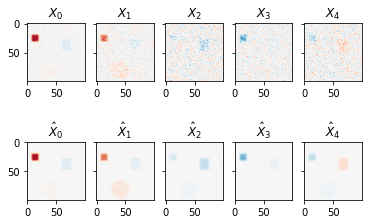

In [9]:
# Plot data and reconstructions
fig, axs = plt.subplots(2, 5, sharey=True)
reconstruction = seminmf.compute_mean(data, loadings, weights)
for m in range(5):
    vmax = abs(data[m]).max()
    axs[0, m].imshow(data[m], vmin=-vmax, vmax=vmax, cmap="RdBu")
    axs[0, m].set_title(r"$X_{}$".format(m))
    
    axs[1, m].imshow(reconstruction[m], vmin=-vmax, vmax=vmax, cmap="RdBu")
    axs[1, m].set_title(r"$\hat{{X}}_{}$".format(m))

## Conclusion

It's working for this super simple example! 

**Notes**:
- Unsurprisingly, initialization proved to be important for this coordinate ascent algorithm. We used a simple heuristic of initializing with the SVD, flipping signs and rescaling the singular vectors to fit the model requirements. It seems to work well for this example, but we'll see how it does on real data.

- The loading updates are still pretty slow. I wonder if we could JAX-ify the proximal gradient descent function and `vmap` it over mice. That would require rewriting the `for` and `while` loops in the backtracking line search in a JAX-friendly way.